In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from xgboost import XGBClassifier, XGBRegressor
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from statsmodels.stats.outliers_influence import variance_inflation_factor

class MachineLearning:
    
    def CompareClassifiers(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        n = len(np.unique(y))
        if n == 2:
            methods = [KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(),
                       AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), LogisticRegression(),
                       SVC()]
            strs = ['KNN', 'NB', 'DT', 'RF', 'AB', 'GB', 'XGB', 'Log', 'SVM']
        else:
            methods = [KNeighborsClassifier(), MultinomialNB(), DecisionTreeClassifier(), RandomForestClassifier(),
                       AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), SVC()]
            strs = ['KNN', 'NB', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        train_acc = []
        test_acc = []
        for i in range(len(methods)):
            clf = methods[i].fit(X_train, y_train)
            train_acc.append(clf.score(X_train, y_train))
            test_acc.append(clf.score(X_test, y_test))
        c1 = pd.DataFrame(strs)
        c2 = pd.DataFrame(train_acc)
        c3 = pd.DataFrame(test_acc)
        results = pd.concat([c1, c2, c3], axis='columns')
        results.columns = ['Model', 'train_acc', 'test_acc']
        return results
    
    def CompareRegressors(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        n = len(np.unique(y))
        methods = [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),
                       AdaBoostRegressor(), GradientBoostingRegressor(), XGBRegressor(), SVR()]
        strs = ['Lin', 'KNN', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        train_acc = []
        test_acc = []
        for i in range(len(methods)):
            reg = methods[i].fit(X_train, y_train)
            train_acc.append(reg.score(X_train, y_train))
            test_acc.append(reg.score(X_test, y_test))
        c1 = pd.DataFrame(strs)
        c2 = pd.DataFrame(train_acc)
        c3 = pd.DataFrame(test_acc)
        results = pd.concat([c1, c2, c3], axis='columns')
        results.columns = ['Model', 'train_acc', 'test_acc']
        return results
    
    def Optimize(self, model, parameters, X, y, metric='accuracy'):
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            return GridSearchCV(model, parameters, cv=5, scoring=metric, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        except:
            return GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        
    def PipeIt(self, scaler, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        pipe = Pipeline([('scaler', scaler), ('model', model)]).fit(X_train, y_train)
        return "Training: {}, Validation: {}".format(pipe.score(X_train, y_train), pipe.score(X_test, y_test))


class DataHelper:
    
    def ScaleData(self, strategy, y_var, data):
        X = data.drop([y_var], axis='columns')
        if strategy == 'minmax':
            return MinMaxScaler().fit(X).transform(X)
        if strategy == 'standard':
            return StandardScaler().fit(X).transform(X)
        if strategy == 'mean':
            for col in X.columns:
                X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col]))
            return X
        
    def HoldOut(self, data):
        train, test = train_test_split(data, test_size=0.1)
        return train, test
    
    def MakeNewDF(self, X, y, k):
        selector = SelectKBest(k=k).fit(X, y)
        mask = selector.get_support()
        selected = []
        for i in range(len(mask)):
            if mask[i] == True:
                selected.append(X.columns[i])
        df = pd.DataFrame(selector.transform(X))
        df.columns = selected
        return df
    
    def VifIt(self, X):
        vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
        return vif
        
    
class Evaluater:
    
    def ScoreModel(self, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        algo = model.fit(X_train, y_train)
        return 'Training: {}, Validation: {}'.format(algo.score(X_train, y_train), algo.score(X_test, y_test))
    
    def BuildConfusion(self, fitted_model,  Xval, yval, cmap='plasma'):
        try:
            cm = plot_confusion_matrix(fitted_model, Xval, yval, cmap=cmap)
            return cm
        except:
            return 'Please fit model before passing'
    
    def BuildTree(self, tree):
        try:
            return plot_tree(tree)
        except:
            return 'Please pass a tree class'
    
    def GetCoefficients(self, model, X, y):
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            model.fit(X_train, y_train)
            return 'coefficients: {}'.format(model.coef_)
        except:
            return 'Please pass LinearRegression, LogisticRegression, or an SVM with a linear kernel'
        
    def GetImportance(self, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        model.fit(X_train, y_train)
        try:
            FI = model.feature_importances_
            n_features = X_train.shape[1]
            plt.figure(figsize=(8,8))
            plt.barh(range(n_features), FI, align='center') 
            plt.yticks(np.arange(n_features), X_train.columns.values) 
            plt.xlabel('Feature importance')
            plt.ylabel('Feature')
        except:
            return 'Please pass an ensemble class'
        
    def AUC(self, model, Xval, yval):
        pred = model.predict(Xval)
        fpr, tpr, threshold = roc_curve(yval, pred)
        return auc(fpr, tpr)
    
ml = MachineLearning()
dh = DataHelper()
ev = Evaluater()

In [2]:
df = pd.read_csv(r'C:\Users\aacjp\OneDrive\Desktop\data\tables\Churn3.csv')
val_df = pd.read_csv(r'C:\Users\aacjp\OneDrive\Desktop\data\tables\ChurnValidation.csv')

In [3]:
df = df.drop(['Unnamed: 0'], axis='columns')
df.head()

,international plan,voice mail plan,total day minutes,total eve minutes,total night minutes,total intl minutes,total intl calls,total intl charge,customer service calls,avg duration,churn
0,-0.330299,-0.617569,3.098857,0.320163,1.026054,-0.062618,1.798429,-0.059254,-0.396501,-1.834905,1
1,-0.330299,-0.617569,1.104724,1.804572,-1.547916,-0.117636,-1.093294,-0.118799,0.340701,-0.611839,1
2,3.027557,-0.617569,-0.364096,-1.063769,0.999106,1.370595,-0.516182,1.374029,-1.182043,-0.457325,1
3,-0.330299,-0.617569,-1.293415,-1.154253,-2.176807,0.226748,0.216184,0.222149,0.340701,3.104497,0
4,-0.330299,-0.617569,-0.870597,0.351369,0.172826,-0.219021,-0.793185,-0.217113,2.804019,0.466245,1


In [4]:
val_df = val_df.drop(['Unnamed: 0'], axis='columns')
val_df.head()

,international plan,voice mail plan,total day minutes,total eve minutes,total night minutes,total intl minutes,total intl calls,total intl charge,customer service calls,avg duration,churn
0,-0.330299,-0.617569,-0.259721,0.287563,-0.945242,-0.104049,-0.329646,-0.108533,2.456321,0.617567,1
1,-0.330299,-0.617569,1.140271,1.580368,0.656517,-0.281212,2.239297,-0.280149,-0.089168,-1.089854,1
2,-0.330299,-0.617569,0.267580,-0.478609,2.000093,-1.167316,1.033244,-1.168052,0.340701,0.141379,0
3,-0.330299,-0.617569,0.886469,-0.770141,0.306435,-0.809863,0.216184,-0.810572,-0.420671,-0.571212,0
4,-0.330299,-0.617569,-0.075839,-0.815446,1.167082,0.476964,-0.192346,0.473709,-1.182043,0.632674,0


In [12]:
total_minutes = []
pct_min_intl = []
irreg_calls = []
for i in range(len(df)):
    tm = df['total day minutes'][i] + df['total night minutes'][i] + df['total eve minutes'][i] + df['total intl minutes'][i]
    total_minutes.append(tm)
    pct_min_intl.append(df['total intl minutes'][i] / tm)
    irreg_calls.append(df['total intl calls'][i] + df['customer service calls'][i])
    
df['total minutes'] = total_minutes
df['% intl minutes'] = pct_min_intl
df['irreg calls'] = irreg_calls

df.head()

,international plan,voice mail plan,total day minutes,total eve minutes,total night minutes,total intl minutes,total intl calls,total intl charge,customer service calls,avg duration,churn,total minutes,% intl minutes,irreg calls
0,-0.330299,-0.617569,3.098857,0.320163,1.026054,-0.062618,1.798429,-0.059254,-0.396501,-1.834905,1,4.382456,-0.014288,1.401927
1,-0.330299,-0.617569,1.104724,1.804572,-1.547916,-0.117636,-1.093294,-0.118799,0.340701,-0.611839,1,1.243744,-0.094582,-0.752593
2,3.027557,-0.617569,-0.364096,-1.063769,0.999106,1.370595,-0.516182,1.374029,-1.182043,-0.457325,1,0.941836,1.455238,-1.698225
3,-0.330299,-0.617569,-1.293415,-1.154253,-2.176807,0.226748,0.216184,0.222149,0.340701,3.104497,0,-4.397728,-0.051560,0.556885
4,-0.330299,-0.617569,-0.870597,0.351369,0.172826,-0.219021,-0.793185,-0.217113,2.804019,0.466245,1,-0.565424,0.387358,2.010834


In [13]:
total_minutes = []
pct_min_intl = []
irreg_calls = []
for i in range(len(val_df)):
    tm = val_df['total day minutes'][i] + val_df['total night minutes'][i] + val_df['total eve minutes'][i] + val_df['total intl minutes'][i]
    total_minutes.append(tm)
    pct_min_intl.append(val_df['total intl minutes'][i] / tm)
    irreg_calls.append(val_df['total intl calls'][i] + val_df['customer service calls'][i])
    
val_df['total minutes'] = total_minutes
val_df['% intl minutes'] = pct_min_intl
val_df['irreg calls'] = irreg_calls

val_df.head()

,international plan,voice mail plan,total day minutes,total eve minutes,total night minutes,total intl minutes,total intl calls,total intl charge,customer service calls,avg duration,churn,total minutes,% intl minutes,irreg calls
0,-0.330299,-0.617569,-0.259721,0.287563,-0.945242,-0.104049,-0.329646,-0.108533,2.456321,0.617567,1,-1.021449,0.101864,2.126675
1,-0.330299,-0.617569,1.140271,1.580368,0.656517,-0.281212,2.239297,-0.280149,-0.089168,-1.089854,1,3.095943,-0.090832,2.150130
2,-0.330299,-0.617569,0.267580,-0.478609,2.000093,-1.167316,1.033244,-1.168052,0.340701,0.141379,0,0.621749,-1.877472,1.373945
3,-0.330299,-0.617569,0.886469,-0.770141,0.306435,-0.809863,0.216184,-0.810572,-0.420671,-0.571212,0,-0.387100,2.092131,-0.204487
4,-0.330299,-0.617569,-0.075839,-0.815446,1.167082,0.476964,-0.192346,0.473709,-1.182043,0.632674,0,0.752761,0.633620,-1.374389


In [14]:
sample = df
sv = val_df

In [15]:
X = sample.drop(['churn'], axis='columns')
Xval = sv.drop(['churn'], axis='columns')
y = sample['churn']
yval = sv['churn']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = XGBClassifier(learning_rate=0.2, max_depth=6, subsample=0.7)
model.fit(X_train, y_train)
print('Training: {}'.format(model.score(X_train, y_train)))
print('Testing: {}'.format(model.score(X_test, y_test)))
print('Validation: {}'.format(model.score(Xval, yval)))

Training: 1.0
Testing: 0.9689922480620154
Validation: 0.9935483870967742


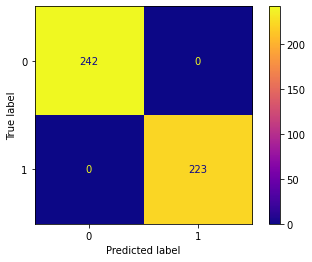

In [17]:
fitted_model = model.fit(X, y)
ev.BuildConfusion(fitted_model, Xval, yval)

In [18]:
ev.AUC(model, Xval, yval)

1.0

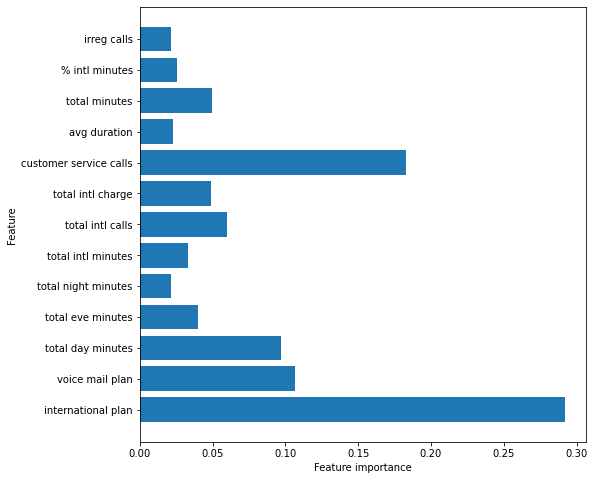

In [19]:
ev.GetImportance(model, X, y)

In [20]:
ml.CompareClassifiers(X, y)

,Model,train_acc,test_acc
0,KNN,0.927320,0.891473
1,NB,0.617064,0.615848
2,DT,1.000000,0.904393
3,RF,1.000000,0.956934
4,AB,0.901465,0.897502
5,GB,0.968113,0.961240
6,XGB,0.968113,0.963824
7,Log,0.795748,0.784668
8,SVM,0.640333,0.639966


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    9.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.8s finished


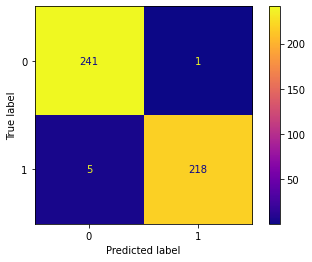

In [23]:
parameters = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
clf = ml.Optimize(XGBClassifier(), parameters, X, y)
score = ev.ScoreModel(clf, X, y)
auc = ev.AUC(clf, Xval, yval)
fit = clf.fit(X, y)
ev.BuildConfusion(fit, Xval, yval)

In [24]:
clf

XGBClassifier(max_depth=6, subsample=0.7)

In [25]:
score

'Training: 0.993105429474289, Validation: 0.9724375538329026'

In [26]:
auc

0.9844809694993144

In [27]:
df2 = dh.MakeNewDF(X, y, 10)
val2 = Xval[list(df2.columns)]

In [29]:
df2.head()

,international plan,voice mail plan,total day minutes,total eve minutes,total intl minutes,total intl charge,customer service calls,avg duration,total minutes,irreg calls
0,-0.330299,-0.617569,3.098857,0.320163,-0.062618,-0.059254,-0.396501,-1.834905,4.382456,1.401927
1,-0.330299,-0.617569,1.104724,1.804572,-0.117636,-0.118799,0.340701,-0.611839,1.243744,-0.752593
2,3.027557,-0.617569,-0.364096,-1.063769,1.370595,1.374029,-1.182043,-0.457325,0.941836,-1.698225
3,-0.330299,-0.617569,-1.293415,-1.154253,0.226748,0.222149,0.340701,3.104497,-4.397728,0.556885
4,-0.330299,-0.617569,-0.870597,0.351369,-0.219021,-0.217113,2.804019,0.466245,-0.565424,2.010834


In [31]:
val2.head()

,international plan,voice mail plan,total day minutes,total eve minutes,total intl minutes,total intl charge,customer service calls,avg duration,total minutes,irreg calls
0,-0.330299,-0.617569,-0.259721,0.287563,-0.104049,-0.108533,2.456321,0.617567,-1.021449,2.126675
1,-0.330299,-0.617569,1.140271,1.580368,-0.281212,-0.280149,-0.089168,-1.089854,3.095943,2.150130
2,-0.330299,-0.617569,0.267580,-0.478609,-1.167316,-1.168052,0.340701,0.141379,0.621749,1.373945
3,-0.330299,-0.617569,0.886469,-0.770141,-0.809863,-0.810572,-0.420671,-0.571212,-0.387100,-0.204487
4,-0.330299,-0.617569,-0.075839,-0.815446,0.476964,0.473709,-1.182043,0.632674,0.752761,-1.374389


In [33]:
ml.CompareClassifiers(df2, y)

,Model,train_acc,test_acc
0,KNN,0.935938,0.889750
1,NB,0.793450,0.799311
2,DT,1.000000,0.901809
3,RF,1.000000,0.949182
4,AB,0.885090,0.894057
5,GB,0.965814,0.956934
6,XGB,0.957483,0.946598
7,Log,0.791152,0.806202
8,SVM,0.916978,0.898363


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   11.1s finished


GradientBoostingClassifier(max_depth=9, min_samples_leaf=2, n_estimators=250)
Training: 1.0, Validation: 0.958656330749354


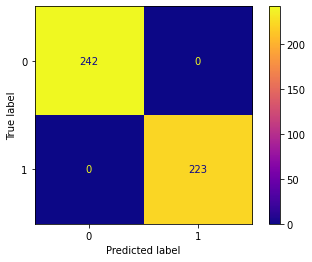

In [40]:
parameters = {'min_samples_leaf': [1.5, 2, 2.5]}
clf = ml.Optimize(GradientBoostingClassifier(n_estimators=250, max_depth=9), parameters, df2, y)
score = ev.ScoreModel(clf, df2, y)
fit = clf.fit(df2, y)
ev.BuildConfusion(fit, val2, yval)
print(clf)
print(score)

In [41]:
model = GradientBoostingClassifier(max_depth=9, min_samples_leaf=2, n_estimators=250)

In [46]:
final = pd.concat([df2, y], axis='columns')
final_val = pd.concat([val2, yval], axis='columns')

In [49]:
final.to_csv('FinalChurnVal.csv')
final.to_csv('FinalChurn.csv')